# BACH Dataset Exploration

[Check this out](https://iciar2018-challenge.grand-challenge.org/Data) for information about the structure of the dataset

In [1]:
import os
import sys

parent = os.path.dirname(os.path.dirname(os.getcwd()))
if parent not in sys.path:
    sys.path.append(parent)
    
bach_train_folder = os.path.join(parent,"data","processed","BACH_TRAIN")

# Structure
There is a photos folder and a WSI (whole slide image) folder. In the photos folder, there are four smaller folders each containing 100 images. They are:
- **Benign** - Non Cancerous
- **InSitu** - Cancerous
- **Invasive** - Cancerous
- **Normal** - Non Cancerous

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
img = Image.open(os.path.join(bach_train_folder,"Benign","b002.tif"))
plt.imshow(img)
img = ToTensor()(img)

# Segmentation Quality and Vizualising the Cell Prediction

In [3]:
# MODEL
from src.model.architectures.graph_construction.hover_net import HoVerNet
chkpt = "HoVerNet_MD-3.2.ckpt"
chkpt_path = os.path.join(parent,"experiments","checkpoints",chkpt)

model = HoVerNet.load_from_checkpoint(chkpt_path, RESNET_SIZE=50,START_LR=0)

In [4]:
from src.transforms.graph_construction.hovernet_post_processing import instance_mask_prediction_hovernet,cut_img_from_tile
from src.transforms.graph_construction.percolation import hollow
tile_size=128

ins_pred = instance_mask_prediction_hovernet(model, img,tile_size)
img_trans = cut_img_from_tile(img,tile_size)
hl_pred = hollow(ins_pred)

Hollowing: 100%|██████████| 1408/1408 [01:49<00:00, 12.85it/s]


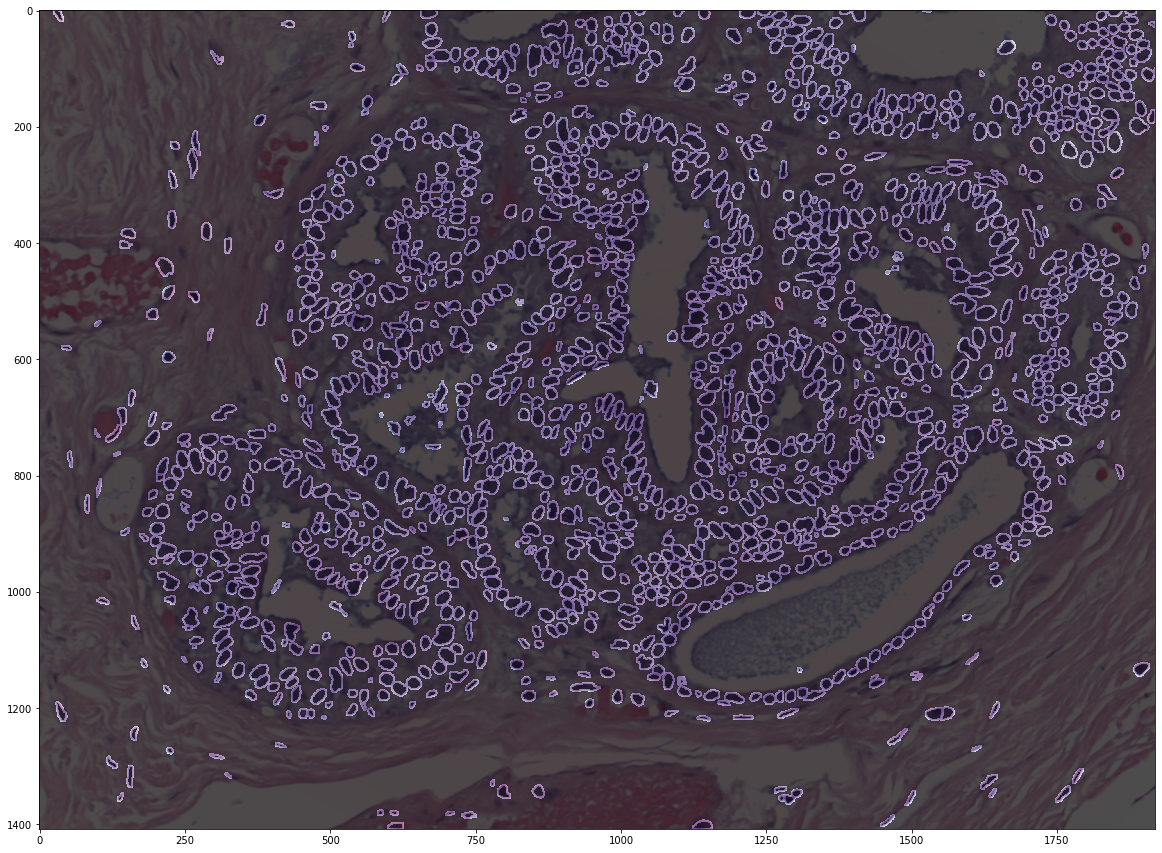

In [5]:
from numpy.ma import masked_where

from src.utilities.img_utilities import tensor_to_numpy

f,ax = plt.subplots(1,1,figsize=(20,20))


ax.imshow(tensor_to_numpy(img_trans))
ax.imshow(masked_where(hl_pred!=0,hl_pred),cmap="nipy_spectral",alpha=0.7)
plt.show()

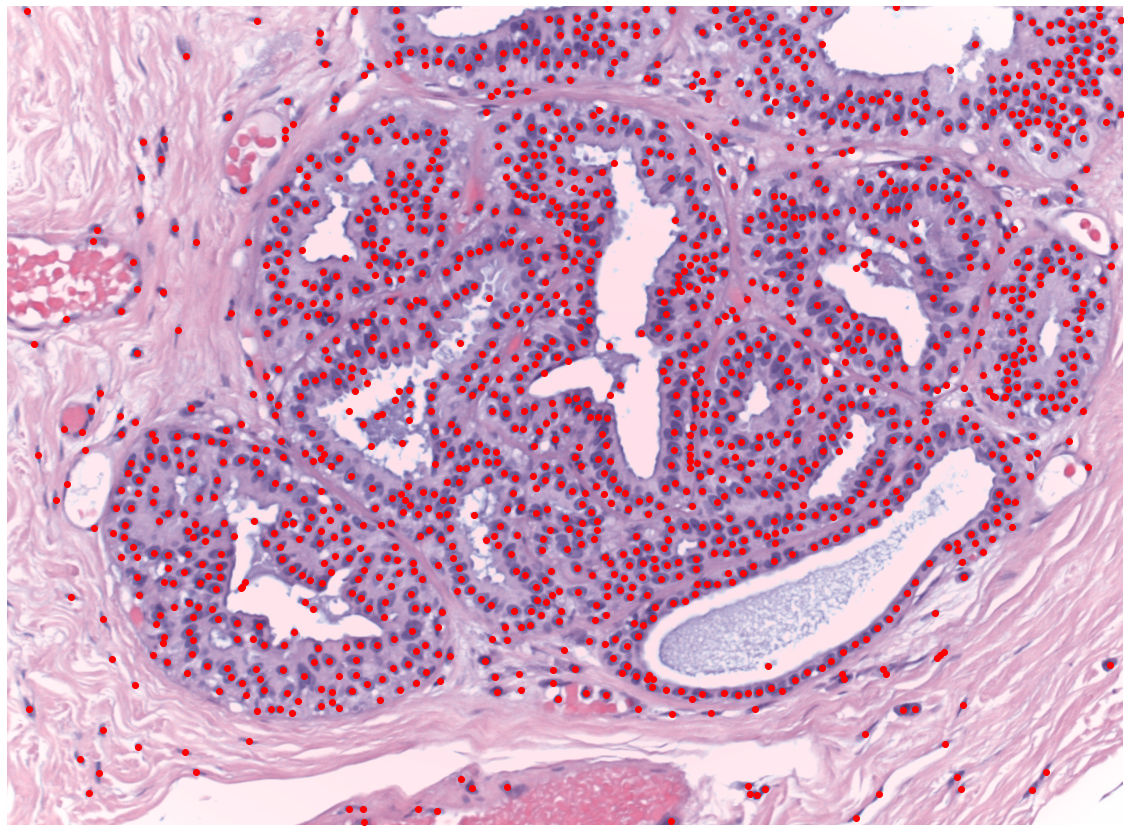

In [6]:
from src.utilities.tensor_utilties import reset_ids
from src.transforms.graph_construction.hover_maps import find_centre_of_mass

f = plt.figure(figsize=(20,20))
ax = plt.subplot()
ax.imshow(tensor_to_numpy(img_trans))
ax.set_axis_off()
nuclei_count = ins_pred.max()
for i in range(1,nuclei_count+1):
    x,y = find_centre_of_mass(ins_pred,i)
    ax.scatter([x],[y],c="red")



# Graph Construction

In [7]:
from src.transforms.graph_construction.graph_extractor import extract_graph

extract_graph(img_trans,ins_pred,k=4,window_size=50,downsample=2)

Data(edge_index=[2, 7270], x=[1520, 1875], edge_attr=[7270, 1], pos=[1520, 2])